In [2]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sentence_transformers.cross_encoder import CrossEncoder

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

import multiprocessing

import matplotlib.pyplot as plt

import warnings

from transformers import AutoTokenizer
from datasets import Dataset
import seaborn as sns

import numpy as np
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

In [3]:
multiprocessing.cpu_count()

64

In [4]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type):
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


In [5]:
json_citing_train = load_json_data("datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [6]:
citing_dataset_df = pd.DataFrame(json_citing_test)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)
citing_dataset_df.shape, nonciting_dataset_df.shape, mapping_dataset_df.shape

((1000, 4), (16837, 4), (8594, 5))

In [7]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3708804,2020-09-16,A1,"{'title': 'IMPELLER TIP CAVITY', 'pa01': 'A ga..."
1,3636792,2020-04-15,A1,{'title': 'NOVEL AUSTENITIC ALLOYS FOR TURBOCH...
2,3714916,2020-09-30,A1,{'title': 'WOUND THERAPY DEVICE PRESSURE MONIT...
3,3715215,2020-09-30,A1,"{'title': 'STEERING SYSTEM', 'pa01': 'Provided..."
4,3587192,2020-01-01,A1,"{'title': 'POWER SUPPLY DEVICE', 'pa01': 'An o..."
...,...,...,...,...
995,3706185,2020-09-09,A1,{'title': 'ORGANIC LIGHT-EMITTING DEVICE AND E...
996,3734417,2020-11-04,A1,{'title': 'HEAD MOUNTED DISPLAY SYSTEM CAPABLE...
997,3736777,2020-11-11,A1,{'title': 'METHOD AND SYSTEM FOR DETERMINING T...
998,3739626,2020-11-18,A1,{'title': 'ELECTRONIC PACKAGE WITH ROTATED SEM...


In [8]:
citing_dataset_df['Application_Number'].value_counts().sort_values(ascending=False).head(10)

Application_Number
3708804    1
3588969    1
3731602    1
3667544    1
3714916    1
3715215    1
3587192    1
3641320    1
3681203    1
3595111    1
Name: count, dtype: int64

In [9]:
citing_dataset_df['App_ID'] = citing_dataset_df['Application_Number'].astype(str) + citing_dataset_df['Application_Category'].astype(str)

In [10]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content,App_ID
0,3708804,2020-09-16,A1,"{'title': 'IMPELLER TIP CAVITY', 'pa01': 'A ga...",3708804A1
1,3636792,2020-04-15,A1,{'title': 'NOVEL AUSTENITIC ALLOYS FOR TURBOCH...,3636792A1
2,3714916,2020-09-30,A1,{'title': 'WOUND THERAPY DEVICE PRESSURE MONIT...,3714916A1
3,3715215,2020-09-30,A1,"{'title': 'STEERING SYSTEM', 'pa01': 'Provided...",3715215A1
4,3587192,2020-01-01,A1,"{'title': 'POWER SUPPLY DEVICE', 'pa01': 'An o...",3587192A1
...,...,...,...,...,...
995,3706185,2020-09-09,A1,{'title': 'ORGANIC LIGHT-EMITTING DEVICE AND E...,3706185A1
996,3734417,2020-11-04,A1,{'title': 'HEAD MOUNTED DISPLAY SYSTEM CAPABLE...,3734417A1
997,3736777,2020-11-11,A1,{'title': 'METHOD AND SYSTEM FOR DETERMINING T...,3736777A1
998,3739626,2020-11-18,A1,{'title': 'ELECTRONIC PACKAGE WITH ROTATED SEM...,3739626A1


In [11]:
nonciting_dataset_df['App_ID'] = nonciting_dataset_df['Application_Number'].astype(str) + nonciting_dataset_df['Application_Category'].astype(str)
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,App_ID
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",2019772B1
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",2136094B1
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...",2340701A2
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,2338661A1
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,2339144A2
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...",1995910B1
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,1997557B1
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",1992846B1
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,1981195B1


In [11]:
citing_dataset_df['Application_Category'].unique(), nonciting_dataset_df['Application_Category'].unique()

(array(['A1', 'A9'], dtype=object),
 array(['B1', 'A2', 'A1', 'B9', 'B2', 'B3'], dtype=object))

In [12]:
mapping_dataset_df

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [13]:
mapping_dataset_df['cat1'] = mapping_dataset_df[0].astype(str).str[-2:]
mapping_dataset_df['cat2'] = mapping_dataset_df[2].astype(str).str[-2:]

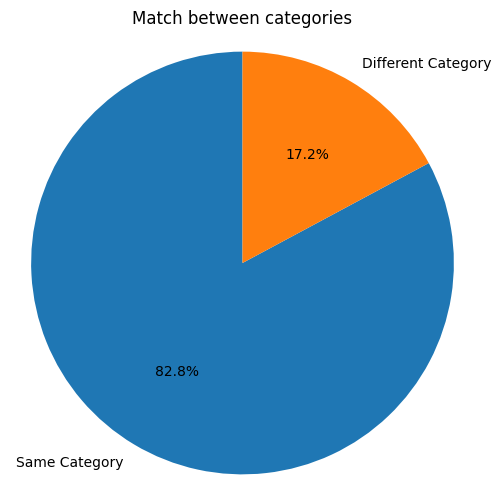

In [14]:
mapping_dataset_df['same_category'] = mapping_dataset_df['cat1'] == mapping_dataset_df['cat2']

category_match_counts = mapping_dataset_df['same_category'].value_counts()

labels = ['Same Category', 'Different Category']
sizes = [category_match_counts[True], category_match_counts[False]]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Match between categories')
plt.axis('equal')
plt.show()

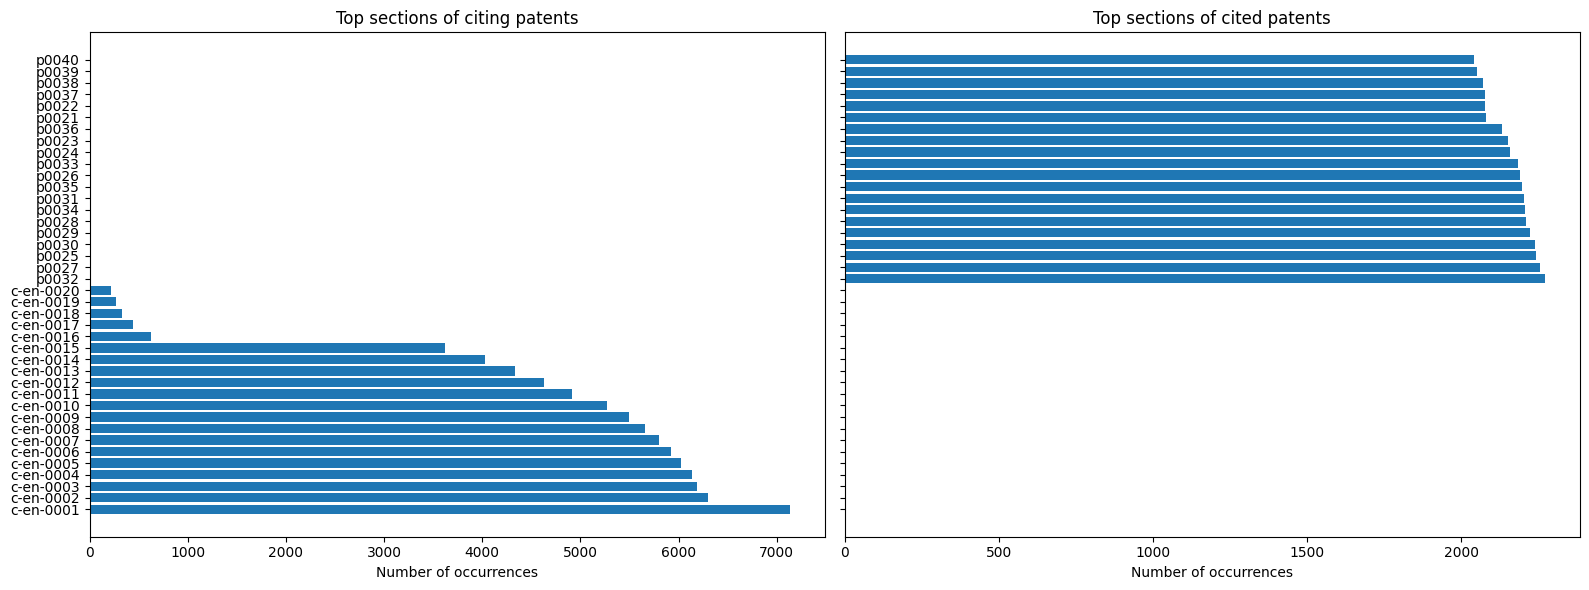

In [15]:
import matplotlib.pyplot as plt

keys_citant = mapping_dataset_df[1].astype(str)
keys_cité = mapping_dataset_df[3].astype(str)

import re
from collections import Counter

def extract_keys(series):
    all_keys = []
    for val in series:
        tokens = re.findall(r'\b[\w\-]+\b', val)
        all_keys.extend(tokens)
    return all_keys

flat_keys_citant = extract_keys(keys_citant)
flat_keys_cité = extract_keys(keys_cité)

counter_citant = Counter(flat_keys_citant)
counter_cité = Counter(flat_keys_cité)

top_citant = counter_citant.most_common(20)
top_cité = counter_cité.most_common(20)

labels_citant, values_citant = zip(*top_citant)
labels_cité, values_cité = zip(*top_cité)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].barh(labels_citant, values_citant)
axes[0].set_title('Top sections of citing patents')
axes[0].invert_yaxis()
axes[0].set_xlabel("Number of occurrences") 

axes[1].barh(labels_cité, values_cité)
axes[1].set_title('Top sections of cited patents')
axes[1].invert_yaxis()
axes[1].set_xlabel("Number of occurrences")

plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


citing_dataset_df['App_ID'] = citing_dataset_df['Application_Number'].astype(str) + citing_dataset_df['Application_Category'].astype(str)
nonciting_dataset_df['App_ID'] = nonciting_dataset_df['Application_Number'].astype(str) + nonciting_dataset_df['Application_Category'].astype(str)

mapping_dataset_df[1] = mapping_dataset_df[1].progress_apply(lambda x: eval(x) if isinstance(x, str) else x)
mapping_dataset_df[3] = mapping_dataset_df[3].progress_apply(lambda x: eval(x) if isinstance(x, str) else x)

citing_content = dict(zip(citing_dataset_df['App_ID'], citing_dataset_df['Content']))
nonciting_content = dict(zip(nonciting_dataset_df['App_ID'], nonciting_dataset_df['Content']))

def extract_pairs(row):
    anchor_id = row[0]
    pos_id = row[2]
    anchor_sections = row[1]
    pos_sections = row[3]

    if anchor_id not in citing_content or pos_id not in nonciting_content:
        return []

    anchor_doc = citing_content[anchor_id]
    pos_doc = nonciting_content[pos_id]

    pairs = []
    for a_key in anchor_sections:
        for p_key in pos_sections:
            if a_key in anchor_doc and p_key in pos_doc:
                pairs.append({
                    'anchor_id': anchor_id,
                    'pos_id': pos_id,
                    'anchor_section': a_key,
                    'pos_section': p_key,
                    'anchor': anchor_doc[a_key],
                    'positive': pos_doc[p_key]
                })
    return pairs

all_pairs = mapping_dataset_df.progress_apply(extract_pairs, axis=1)
flat_pairs = [pair for sublist in all_pairs for pair in sublist]
pairs_df = pd.DataFrame(flat_pairs)

  0%|          | 0/8594 [00:00<?, ?it/s]

  0%|          | 0/8594 [00:00<?, ?it/s]

  0%|          | 0/8594 [00:00<?, ?it/s]

In [19]:
pairs_df

,anchor_id,pos_id,anchor_section,pos_section,anchor,positive
0,3712070A1,3354576A1,c-en-0004,p0024,The environmental control system of any preced...,The following descriptions should not be consi...
1,3712070A1,3354576A1,c-en-0004,p0027,The environmental control system of any preced...,"With reference now to FIG. 1, a schematic diag..."
2,3712070A1,3354576A1,c-en-0004,c-en-0012,The environmental control system of any preced...,"The environmental control system of claim 10, ..."
3,3712070A1,3354576A1,c-en-0004,c-en-0013,The environmental control system of any preced...,"The environmental control system of claim 10, ..."
4,3675165A1,3336831A2,c-en-0001,p0045,"A light emitting diode display apparatus, comp...",FIG. 1 is a diagram for describing a light emi...
...,...,...,...,...,...,...
1871395,3588557A1,2988328A1,c-en-0009,p0012,"The package structure according to claim 6, fu...","In the following, the invention will be descri..."
1871396,3588557A1,2988328A1,c-en-0010,p0047,The package structure (1) according to claim 2...,Figure 4 shows an example of a possible coolin...
1871397,3588557A1,2988328A1,c-en-0010,p0012,The package structure (1) according to claim 2...,"In the following, the invention will be descri..."
1871398,3657819A1,3334179A1,c-en-0010,p0072,"The assembly of any of claims 1-9, wherein the...",The aspects of the disclosure may be best unde...


In [20]:
# to csv
pairs_df.to_csv("train.csv", index=False)

In [6]:
pairs_df = pd.read_csv("train.csv")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def count_tokens(text):
    return len(tokenizer.tokenize(text, add_special_tokens=False))

filtered_df = pairs_df.dropna(subset=["anchor", "positive"])
sampled_df = filtered_df.sample(n=100000, random_state=42)

pairs_ds = Dataset.from_pandas(sampled_df)

pairs_ds = pairs_ds.map(
    lambda x: {
        'anchor_n_tokens': count_tokens(x['anchor']),
        'positive_n_tokens': count_tokens(x['positive'])
    },
    num_proc=multiprocessing.cpu_count()
)

df_plot = pairs_ds.to_pandas()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(y=df_plot["anchor_n_tokens"], ax=ax[0])
ax[0].axhline(512, color='red', linestyle='--')
ax[0].set_title("Anchor Token Count")

sns.violinplot(y=df_plot["positive_n_tokens"], ax=ax[1])
ax[1].axhline(512, color='red', linestyle='--')
ax[1].set_title("Positive Token Count")

plt.tight_layout()
plt.show()

In [6]:
!pip install rank_bm25

In [1]:
import os
import re
import nltk
import spacy
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from rank_bm25 import BM25Okapi
from gensim.models import FastText

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stop_words = set(stopwords.words('english'))

try:
    nlp = spacy.load('en_core_web_sm')
except:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

def clean_text_tokens(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in stop_words]
    return tokens

def clean_text_tokens_keep_stopwords(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3]
    return tokens

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return lemmas

def preprocess_query_dataset(hf_dataset):
    def process(example):
        text = example["c"]
        cleaned = clean_text_tokens(text)
        lemmatized = lemmatize_tokens(cleaned)
        example["c_cleaned"] = cleaned
        example["c_lemmatized"] = lemmatized
        example["vec_tmp"] = []
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def generate_pos_mask(tokens, pos_tags={"VERB", "NOUN", "PROPN", "ADJ"}):
    doc = nlp(" ".join(tokens))
    mask = [token.pos_ in pos_tags for token in doc]
    return mask

def filter_topk_tokens(tokens, bm25, top_k=3):
    scores = []
    for token.lemma_ in tokens:
        score = sum(bm25.get_scores([token])) / len(bm25.corpus) if bm25.corpus else 0
        scores.append((token, score))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [token for token, _ in scores[:top_k]]

def apply_bm25_filter(hf_dataset, bm25, top_k=3):
    def process(example):
        mask = generate_pos_mask(example["c_cleaned"])
        tokens_to_filter = [tok for tok, m in zip(example["c_cleaned"], mask) if m]
        top_tokens = filter_topk_tokens(tokens_to_filter, bm25, top_k)
        example["topk"] = top_tokens
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def train_fasttext_model(hf_dataset, column="c", vector_size=100, window=5, min_count=1, epochs=5):
    texts = hf_dataset[column]
    tokenized_texts = [clean_text_tokens_keep_stopwords(text) for text in texts]
    model = FastText(vector_size=vector_size, window=window, min_count=min_count)
    model.build_vocab(sentences=tokenized_texts)
    model.train(sentences=tokenized_texts, total_examples=len(tokenized_texts), epochs=epochs)
    return model

def expand_tokens_with_fasttext(hf_dataset, fasttext_model, top_n=3):
    def process(example):
        additional = []
        for token in example["topk"]:
            try:
                similars = fasttext_model.wv.most_similar(token, topn=top_n)
                additional.extend([sim_token for sim_token, _ in similars])
            except Exception:
                continue
        example["c_cleaned"] = list(set(example["c_cleaned"] + additional))
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def compute_bm25_vector(hf_dataset, bm25):
    def process(example):
        query = example["c_cleaned"]
        query = lemmatize_tokens(query)
        scores = bm25.get_scores(query)
        example["vec"] = np.array(scores)
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def pipeline(hf_dataset, bm25_corpus):
    dataset = preprocess_query_dataset(hf_dataset)
    bm25_obj = BM25Okapi(bm25_corpus)
    dataset = apply_bm25_filter(dataset, bm25_obj, top_k=3)
    fasttext_model = train_fasttext_model(dataset, column="c")
    dataset = expand_tokens_with_fasttext(dataset, fasttext_model, top_n=3)
    dataset = compute_bm25_vector(dataset, bm25_obj)
    final_dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["app_nb", "c", "cid", "vec"]])
    return final_dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
import os
import re
import nltk
import spacy
import numpy as np
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from rank_bm25 import BM25Okapi
from gensim.models import FastText

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

stop_words = set(stopwords.words('english'))

try:
    nlp = spacy.load('en_core_web_sm')
except:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

def clean_text_tokens(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in stop_words]
    return tokens

def clean_text_tokens_keep_stopwords(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3]
    return tokens

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha()]
    return lemmas


def preprocess_query_dataset(hf_dataset):
    def process(example):
        text = example["c"]
        cleaned = clean_text_tokens(text)
        lemmatized = lemmatize_tokens(cleaned)
        example["c_cleaned"] = cleaned
        example["c_lemmatized"] = lemmatized
        example["vec_tmp"] = []
        print("Preprocess - c:", text)
        print("Preprocess - c_cleaned:", cleaned)
        print("Preprocess - c_lemmatized:", lemmatized)
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def generate_pos_mask(tokens, pos_tags={"VERB", "NOUN", "PROPN", "ADJ"}):
    doc = nlp(" ".join(tokens))
    mask = [token.pos_ in pos_tags for token in doc]
    return mask

def filter_topk_tokens(tokens, bm25, top_k=3):
    scores = []
    for token in tokens:
        token_lemma = lemmatize_tokens([token])[0]
        scores_list = np.array(bm25.get_scores([token_lemma]))
        avg_score = np.mean(scores_list) if scores_list.size > 0 else 0
        scores.append((token, avg_score))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [token for token, _ in scores[:top_k]]

def apply_bm25_filter(hf_dataset, bm25, top_k=3):
    def process(example):
        mask = generate_pos_mask(example["c_cleaned"])
        tokens_to_filter = [tok for tok, m in zip(example["c_cleaned"], mask) if m]
        top_tokens = filter_topk_tokens(tokens_to_filter, bm25, top_k)
        example["topk"] = top_tokens
        print("BM25 Filter - c_cleaned:", example["c_cleaned"])
        print("BM25 Filter - topk:", top_tokens)
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def train_fasttext_model(hf_dataset, column="c", vector_size=100, window=5, min_count=1, epochs=5):
    texts = list(hf_dataset[column])
    tokenized_texts = [clean_text_tokens_keep_stopwords(text) for text in texts]
    model = FastText(vector_size=vector_size, window=window, min_count=min_count)
    model.build_vocab(corpus_iterable=tokenized_texts)
    model.train(corpus_iterable=tokenized_texts, total_examples=len(tokenized_texts), epochs=epochs)
    print("FastText Model - Vocabulary size:", len(model.wv))
    return model

def expand_tokens_with_fasttext(hf_dataset, fasttext_model, top_n=3):
    def process(example):
        additional = []
        for token in example["topk"]:
            try:
                similars = fasttext_model.wv.most_similar(token, topn=top_n)
                additional.extend([sim_token for sim_token, _ in similars])
                print("FastText Expansion - token:", token)
                print("FastText Expansion - additional tokens:", [sim_token for sim_token, _ in similars])
            except Exception:
                continue
        example["c_cleaned"] = list(set(example["c_cleaned"] + additional))
        print("FastText Expansion - new c_cleaned:", example["c_cleaned"])
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def update_query(hf_dataset):
    def process(example):
        example["c"] = " ".join(example["c_cleaned"])
        return example
    num_proc = os.cpu_count() or 1
    new_dataset = hf_dataset.map(process, num_proc=num_proc)
    return new_dataset

def pipeline(hf_dataset, bm25_corpus, fasttext_model):
    print("=== Preprocessing Dataset ===")
    dataset = preprocess_query_dataset(hf_dataset)
    bm25_obj = BM25Okapi(bm25_corpus)
    
    print("=== Applying BM25 Filter ===")
    dataset = apply_bm25_filter(dataset, bm25_obj, top_k=3)
    
    print("=== Expanding Tokens with FastText ===")
    dataset = expand_tokens_with_fasttext(dataset, fasttext_model, top_n=3)
    
    print("=== Updating Query with Expanded Tokens ===")
    dataset = update_query(dataset)
    
    final_dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["app_nb", "c", "cid"]])
    print("=== Final Dataset ===")
    print(final_dataset)
    return final_dataset

In [14]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,App_ID
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",2019772B1
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",2136094B1
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...",2340701A2
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,2338661A1
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,2339144A2
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...",1995910B1
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,1997557B1
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",1992846B1
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,1981195B1


In [15]:
print(nonciting_dataset_df['Content'][0].keys())

dict_keys(['title', 'c-en-0001', 'c-en-0002', 'c-en-0003', 'c-en-0004', 'c-en-0005', 'c-en-0006', 'c-en-0007', 'c-en-0008', 'c-en-0009', 'c-en-0010', 'c-en-0011', 'c-en-0012', 'c-en-0013', 'c-en-0014', 'p0001', 'p0002', 'p0003', 'p0004', 'p0005', 'p0006', 'p0007', 'p0008', 'p0009', 'p0010', 'p0011', 'p0012', 'p0013', 'p0014', 'p0015', 'p0016', 'p0017', 'p0018', 'p0019', 'p0020', 'p0021', 'p0022', 'p0023', 'p0024', 'p0025', 'p0026', 'p0027', 'p0028', 'p0029', 'p0030', 'p0031', 'p0032', 'p0033', 'p0034', 'p0035', 'p0036', 'p0037', 'p0038', 'p0039', 'p0040', 'p0041', 'p0042', 'p0043', 'p0044', 'p0045', 'p0046', 'p0047', 'p0048', 'p0049', 'p0050', 'p0051', 'p0052', 'p0053', 'p0054', 'p0055', 'p0056', 'p0057', 'p0058', 'p0059', 'p0060', 'p0061', 'p0062', 'p0063', 'p0064', 'p0065', 'p0066', 'p0067', 'p0068', 'p0069', 'p0070', 'p0071', 'p0072', 'p0073', 'p0074', 'p0075', 'p0076', 'p0077', 'p0078', 'p0079', 'p0080', 'p0081', 'p0082', 'p0083', 'p0084', 'p0085', 'p0086', 'p0087', 'p0088'])


In [16]:
import pandas as pd
import json
from datasets import Dataset

extracted_rows = []
for _, row in nonciting_dataset_df.iterrows():
    app_id = row["App_ID"]
    content = row["Content"]
    if isinstance(content, str):
        try:
            content_dict = json.loads(content)
        except Exception:
            continue
    elif isinstance(content, dict):
        content_dict = content
    else:
        continue
    for key, value in content_dict.items():
        if key.startswith("p") and isinstance(value, str) and value.strip() != "":
            extracted_rows.append({"app_nb": app_id, "p": value, "pid": key})

df_extracted = pd.DataFrame(extracted_rows)
grouped = df_extracted.groupby("app_nb", as_index=False).agg({"p": " ".join, "pid": lambda x: ", ".join(x)})
dataset_extracted = Dataset.from_pandas(grouped)
print(dataset_extracted)

Dataset({
    features: ['app_nb', 'p', 'pid'],
    num_rows: 16834
})


In [17]:
os.cpu_count()

96

In [ ]:
def preprocess_p(example):
    tokens = clean_text_tokens(example["p"])
    example["p_preprocessed"] = lemmatize_tokens(tokens)

    return example

dataset_extracted = dataset_extracted.map(preprocess_p, num_proc=os.cpu_count())
corpus = dataset_extracted["p_preprocessed"]
bm25_model = BM25Okapi(corpus)

Map (num_proc=96):   0%|          | 0/16834 [00:00<?, ? examples/s]

In [12]:
model = SentenceTransformer("/home/tau/ialiouch/patent-retrieval-engine/checkpoints/bi-encoder/checkpoint-185", trust_remote_code=True, model_kwargs={"torch_dtype": "bfloat16"})

In [13]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [14]:
!nvidia-smi

Fri Apr 11 00:16:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                Off |   00000000:E3:00.0 Off |                    0 |
| N/A   59C    P0            105W /  400W |    1168MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [15]:
nonciting_extracted = []
for _, row in nonciting_dataset_df.iterrows():
    app_id = row["App_ID"]
    content = row["Content"]
    if isinstance(content, str):
        try:
            content_dict = json.loads(content)
        except Exception:
            continue
    elif isinstance(content, dict):
        content_dict = content
    else:
        continue
    for key, value in content_dict.items():
        if key.startswith("p") and isinstance(value, str) and value.strip() != "":
            nonciting_extracted.append({"app_nb": app_id, "p": value, "pid": key})

df_nonciting = pd.DataFrame(nonciting_extracted)
df_nonciting_sample = (
    df_nonciting.groupby("app_nb", group_keys=False)
              .apply(lambda x: x.sample(n=4, random_state=42) if len(x) >= 4 else x)
              .reset_index(drop=True)
)
nonciting_dataset = Dataset.from_pandas(df_nonciting_sample)
print(nonciting_dataset)

citing_extracted = []
for _, row in citing_dataset_df.iterrows():
    app_id = row["App_ID"]
    content = row["Content"]
    if isinstance(content, str):
        try:
            content_dict = json.loads(content)
        except Exception:
            continue
    elif isinstance(content, dict):
        content_dict = content
    else:
        continue
    for key, value in content_dict.items():
        if key.startswith("p") and isinstance(value, str) and value.strip() != "":
            citing_extracted.append({"app_nb": app_id, "c": value, "cid": key})

df_citing = pd.DataFrame(citing_extracted)
df_citing_sample = (
    df_citing.groupby("app_nb", group_keys=False)
           .apply(lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x)
           .reset_index(drop=True)
)
citing_dataset = Dataset.from_pandas(df_citing_sample)
print(citing_dataset)

Dataset({
    features: ['app_nb', 'p', 'pid'],
    num_rows: 67336
})
Dataset({
    features: ['app_nb', 'c', 'cid'],
    num_rows: 10000
})


In [17]:
import gc

def compute_similarity_datasets(citing_dataset, nonciting_dataset, model, batch_size=2096):
    citing_encodings = model.encode(citing_dataset["c"], batch_size=batch_size, convert_to_tensor=True, show_progess_bar=True)
    nonciting_encodings = model.encode(nonciting_dataset["p"], batch_size=batch_size, convert_to_tensor=True, show_progress_bar=True)
    del model
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    similarity_matrix = cos_sim(citing_encodings, nonciting_encodings)
    del citing_encodings
    del nonciting_encodings
    gc.collect()
    scores_list = similarity_matrix.cpu().tolist()

    citing_dict = citing_dataset.to_dict()
    citing_dict["scores"] = scores_list
    new_citing_dataset = Dataset.from_dict(citing_dict)
    new_nonciting_dataset = nonciting_dataset.select(range(len(nonciting_dataset)))
    
    return new_citing_dataset, new_nonciting_dataset

In [18]:
scores_dataset, nonciting_dataset_final = compute_similarity_datasets(citing_dataset, nonciting_dataset, model)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [25]:
len(scores_dataset[0]['scores'])

67336

In [26]:
scores_dataset

Dataset({
    features: ['app_nb', 'c', 'cid', 'scores'],
    num_rows: 10000
})

In [24]:
nonciting_dataset_final

Dataset({
    features: ['app_nb', 'p', 'pid'],
    num_rows: 67336
})

In [12]:
import numpy as np
from datasets import Dataset

def aggregate_reciprocal_fusion(scores_dataset, nonciting_dataset_final, top_k=100):
    mapping = nonciting_dataset_final.to_dict()

    def process_row(row, top_k):
        scores = np.array(row["scores"])
        sorted_indices = np.argsort(scores)[::-1]
        selected_scores = []
        selected_refs = []
        seen = set()
        for idx in sorted_indices:
            nonciting_app = mapping["app_nb"][idx]
            nonciting_pid = mapping["pid"][idx]
            if nonciting_app not in seen:
                seen.add(nonciting_app)
                selected_scores.append(float(scores[idx]))
                selected_refs.append((nonciting_app, nonciting_pid))
                if len(seen) >= top_k:
                    break
        return {
            "app_nb": row["app_nb"],
            "cid": row["cid"],
            "scores": selected_scores,
            "app_nb_pids": selected_refs
        }

    intermediate = [process_row(row, top_k) for row in scores_dataset]

    grouped = {}
    for item in intermediate:
        key = item["app_nb"]
        if key not in grouped:
            grouped[key] = {"scores": [], "app_nb_pids": []}
        grouped[key]["scores"].extend(item["scores"])
        grouped[key]["app_nb_pids"].extend(item["app_nb_pids"])

    final_results = []
    for app_nb, data in grouped.items():
        scores_arr = np.array(data["scores"])
        refs_list = data["app_nb_pids"]
        sorted_indices = np.argsort(scores_arr)[::-1]
        final_scores = []
        final_refs = []
        seen = set()
        for idx in sorted_indices:
            ref = refs_list[idx]
            nonciting_app = ref[0]
            if nonciting_app not in seen:
                seen.add(nonciting_app)
                final_scores.append(float(scores_arr[idx]))
                final_refs.append(ref)
                if len(seen) >= top_k:
                    break
        final_results.append({
            "app_nb": app_nb,
            "scores": final_scores,
            "app_nb_pids": final_refs
        })

    final_dataset = Dataset.from_dict({
        "app_nb": [item["app_nb"] for item in final_results],
        "scores": [item["scores"] for item in final_results],
        "app_nb_pids": [item["app_nb_pids"] for item in final_results]
    })
    return final_dataset


In [28]:
dense_final_100_dataset = aggregate_reciprocal_fusion(scores_dataset, nonciting_dataset_final)

In [29]:
dense_final_100_dataset

Dataset({
    features: ['app_nb', 'scores', 'app_nb_pids'],
    num_rows: 1000
})

In [ ]:
dense_final_100_datasetb = dense_final_100_dataset.to_dict()
dense_final_100_datasetb = {
    "app_nb": dense_final_100_datasetb["app_nb"],
    "app_nb_pids": dense_final_100_datasetb["app_nb_pids"]
}

print(dense_final_100_datasetb)

In [33]:
json_output = json.dumps(dense_final_100_datasetb, indent=2)

print(json_output)

with open("dense_final_100_dataset.json", "w") as f:
    f.write(json_output)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
!nvidia-smi

Fri Apr 11 00:10:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                Off |   00000000:E3:00.0 Off |                    0 |
| N/A   57C    P0            104W /  400W |     526MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import json

with open("dense_final_100_dataset.json", "r") as f:
    dense_final_100_dataset = json.load(f)

print(dense_final_100_dataset)

In [20]:
new_data = {str(app): [pid[0] for pid in pids] for app, pids in zip(dense_final_100_dataset["app_nb"], dense_final_100_dataset["app_nb_pids"])}

with open("dense_final_100_dataset_reloaded.json", "w") as f:
    json.dump(new_data, f, indent=2)

In [29]:
with open("top100_sparse.json", "r") as f:
    sparse_top_100 = json.load(f)

In [ ]:
print(sparse_top_100)

In [31]:
new_data2 = {str(app): pids for app, pids in zip(sparse_top_100["app_nb"], sparse_top_100["app_nb_pids"])}

with open("top100_reloaded.json", "w") as f:
    json.dump(new_data2, f, indent=2)

In [32]:
dataset_dict_dense = {
    "app_nb_cid": list(new_data.keys()),
    "app_nb_pids": list(new_data.values())
}

dataset_dense = Dataset.from_dict(dataset_dict_dense)
print(dataset_dense)

Dataset({
    features: ['app_nb_cid', 'app_nb_pids'],
    num_rows: 1000
})


In [ ]:
print(new_data2)

In [34]:
dataset_dict_sparse = {
    "app_nb_cid": list(new_data2.keys()),
    "app_nb_pids": list(new_data2.values())
}

dataset_sparse = Dataset.from_dict(dataset_dict_sparse)
print(dataset_sparse)

Dataset({
    features: ['app_nb_cid', 'app_nb_pids'],
    num_rows: 1000
})


In [35]:
len(dataset_sparse[0]['app_nb_pids'])

100

In [36]:
len(dataset_dense[0]['app_nb_pids'])

100

In [37]:
from datasets import Dataset

def reciprocal_rank_fusion(dataset1, dataset2, k=100, output_path=None):
    dict1 = {}
    dict2 = {}
    
    for item in dataset1:
        dict1[item['app_nb_cid']] = item['app_nb_pids']
    
    for item in dataset2:
        dict2[item['app_nb_cid']] = item['app_nb_pids']
    
    common_cids = set(dict1.keys()) & set(dict2.keys())
    print(f"Processing {len(common_cids)} common citation IDs")
    
    fused_results = []
    
    for cid in common_cids:
        pids_list1 = dict1[cid]
        pids_list2 = dict2[cid]
        
        all_pids = set(pids_list1) | set(pids_list2)
        
        fusion_scores = {}
        
        for rank, pid in enumerate(pids_list1):
            fusion_scores[pid] = 1.0 / (k + rank)
            
        for rank, pid in enumerate(pids_list2):
            if pid in fusion_scores:
                fusion_scores[pid] += 1.0 / (k + rank)
            else:
                fusion_scores[pid] = 1.0 / (k + rank)
        
        sorted_pids = sorted(all_pids, key=lambda pid: fusion_scores.get(pid, 0), reverse=True)
        
        fused_results.append({
            'app_nb_cid': cid,
            'app_nb_pids': sorted_pids
        })
    
    fused_dataset = Dataset.from_list(fused_results)
    
    if output_path:
        fused_dataset.save_to_disk(output_path)
        print(f"Fused dataset saved to '{output_path}'")
    
    return fused_dataset

In [38]:
final_dataset = reciprocal_rank_fusion(dataset_dense, dataset_sparse)

Processing 1000 common citation IDs


In [40]:
print(final_dataset)

Dataset({
    features: ['app_nb_cid', 'app_nb_pids'],
    num_rows: 1000
})


In [41]:
new_data_final = {str(app): pids for app, pids in zip(final_dataset["app_nb_cid"], final_dataset["app_nb_pids"])}

with open("final_retriever.json", "r") as f:
    json.dump(new_data_final, f, indent=2)

In [13]:
with open("final_retriever.json", "r") as f:
    final_dataset = json.load(f)

final_dataset = Dataset.from_dict({
    "app_nb_cid": final_dataset.keys(),
    "app_nb_pids": final_dataset.values()
})

In [14]:
final_dataset

Dataset({
    features: ['app_nb_cid', 'app_nb_pids'],
    num_rows: 1000
})

In [20]:
def reranking(citing_dataset_df, nonciting_dataset_df, final_dataset, cross_encoder_model, sample_c=1, sample_p=1, top_k=100):
    print("=== Extraction and Sampling: Citing ===")
    citing_extracted = []
    for _, row in tqdm(citing_dataset_df.iterrows(), total=citing_dataset_df.shape[0], desc="Extracting citing rows"):
        app_id = row["App_ID"]
        content = row["Content"]
        if isinstance(content, str):
            try:
                content_dict = json.loads(content)
            except Exception:
                continue
        elif isinstance(content, dict):
            content_dict = content
        else:
            continue
        for key, value in content_dict.items():
            if key.startswith("c") and isinstance(value, str) and value.strip() != "":
                citing_extracted.append({"app_nb": app_id, "c": value, "cid": key})
    df_citing = pd.DataFrame(citing_extracted)
    print(f"Total citing rows extracted: {len(df_citing)}")
    df_citing_sample = (df_citing.groupby("app_nb", group_keys=False)
                        .apply(lambda x: x.sample(n=sample_c, random_state=42) if len(x) >= sample_c else x)
                        .reset_index(drop=True))
    citing_dataset = Dataset.from_pandas(df_citing_sample)
    print("Sampled citing dataset:")
    print(citing_dataset)

    print("\n=== Extraction and Sampling: Non-Citing ===")
    nonciting_extracted = []
    for _, row in tqdm(nonciting_dataset_df.iterrows(), total=nonciting_dataset_df.shape[0], desc="Extracting non-citing rows"):
        app_id = row["App_ID"]
        content = row["Content"]
        if isinstance(content, str):
            try:
                content_dict = json.loads(content)
            except Exception:
                continue
        elif isinstance(content, dict):
            content_dict = content
        else:
            continue
        for key, value in content_dict.items():
            if key.startswith("p") and isinstance(value, str) and value.strip() != "":
                nonciting_extracted.append({"app_nb": app_id, "p": value, "pid": key})
    df_nonciting = pd.DataFrame(nonciting_extracted)
    print(f"Total non-citing rows extracted: {len(df_nonciting)}")
    df_nonciting_sample = (df_nonciting.groupby("app_nb", group_keys=False)
                           .apply(lambda x: x.sample(n=sample_p, random_state=42) if len(x) >= sample_p else x)
                           .reset_index(drop=True))
    nonciting_dataset = Dataset.from_pandas(df_nonciting_sample)
    print("Sampled non-citing dataset:")
    print(nonciting_dataset)

    print("\n=== Building Non-Citing Mapping ===")
    nonciting_dict = nonciting_dataset.to_dict()
    nonciting_map = {}
    for idx, app in enumerate(nonciting_dict["app_nb"]):
        if app not in nonciting_map:
            nonciting_map[app] = []
        nonciting_map[app].append({"p": nonciting_dict["p"][idx], "pid": nonciting_dict["pid"][idx]})
    print(f"Non-citing mapping built for {len(nonciting_map)} unique app_nb.")

    print("\n=== Computing CrossEncoder Scores ===")
    citing_data = citing_dataset.to_dict()
    scores_data = []
    for row in tqdm(final_dataset, desc="CrossEncoder scoring"):
        citing_app = row["app_nb_cid"]
        candidate_app_list = row["app_nb_pids"]
        citing_candidates = [x for x, a in zip(citing_data["c"], citing_data["app_nb"]) if a == citing_app]
        if len(citing_candidates) == 0:
            continue
        citing_text = citing_candidates[0]
        score_vector = []
        candidate_ids = []  
        for candidate in candidate_app_list:
            samples = nonciting_map.get(candidate, [])
            if len(samples) == 0:
                score = -float("inf")
            else:
                pairs = [(citing_text, sample["p"]) for sample in samples]
                candidate_scores = cross_encoder_model.predict(pairs, batch_size=2096)
                score = float(np.mean(candidate_scores))
            score_vector.append(score)
            candidate_ids.append(candidate)
        scores_data.append({
            "app_nb": citing_app,
            "c": citing_text,
            "cid": row.get("cid", ""),
            "scores": np.array(score_vector),
            "app_nb_pids": candidate_ids
        })
    print("CrossEncoder scoring completed.")

    scores_dataset = Dataset.from_dict({
        "app_nb": [d["app_nb"] for d in scores_data],
        "c": [d["c"] for d in scores_data],
        "cid": [d["cid"] for d in scores_data],
        "scores": [d["scores"] for d in scores_data],
        "app_nb_pids": [d["app_nb_pids"] for d in scores_data]
    })
    print("Scores dataset constructed:")
    print(scores_dataset)

    print("\n=== Aggregating and Re-ranking ===")
    aggregated_dataset = aggregate_reciprocal_fusion(scores_dataset, nonciting_dataset, top_k=top_k)
    print("Aggregated (fused) dataset:")
    print(aggregated_dataset)
    
    return aggregated_dataset


In [16]:
model = CrossEncoder(
    "Alibaba-NLP/gte-reranker-modernbert-base",
    trust_remote_code=True,
    model_kwargs={"torch_dtype": "bfloat16"}
)

In [17]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content,App_ID
0,3708804,2020-09-16,A1,"{'title': 'IMPELLER TIP CAVITY', 'pa01': 'A ga...",3708804A1
1,3636792,2020-04-15,A1,{'title': 'NOVEL AUSTENITIC ALLOYS FOR TURBOCH...,3636792A1
2,3714916,2020-09-30,A1,{'title': 'WOUND THERAPY DEVICE PRESSURE MONIT...,3714916A1
3,3715215,2020-09-30,A1,"{'title': 'STEERING SYSTEM', 'pa01': 'Provided...",3715215A1
4,3587192,2020-01-01,A1,"{'title': 'POWER SUPPLY DEVICE', 'pa01': 'An o...",3587192A1
...,...,...,...,...,...
995,3706185,2020-09-09,A1,{'title': 'ORGANIC LIGHT-EMITTING DEVICE AND E...,3706185A1
996,3734417,2020-11-04,A1,{'title': 'HEAD MOUNTED DISPLAY SYSTEM CAPABLE...,3734417A1
997,3736777,2020-11-11,A1,{'title': 'METHOD AND SYSTEM FOR DETERMINING T...,3736777A1
998,3739626,2020-11-18,A1,{'title': 'ELECTRONIC PACKAGE WITH ROTATED SEM...,3739626A1


In [18]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,App_ID
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",2019772B1
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",2136094B1
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...",2340701A2
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,2338661A1
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,2339144A2
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...",1995910B1
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,1997557B1
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",1992846B1
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,1981195B1


In [19]:
final_dataset

Dataset({
    features: ['app_nb_cid', 'app_nb_pids'],
    num_rows: 1000
})

In [ ]:
fused_dataset = reranking(citing_dataset_df, nonciting_dataset_df, final_dataset, model, sample_c=1, sample_p=1, top_k=100)

=== Extraction and Sampling: Citing ===


Extracting citing rows:   0%|          | 0/1000 [00:00<?, ?it/s]

Total citing rows extracted: 13547
Sampled citing dataset:
Dataset({
    features: ['app_nb', 'c', 'cid'],
    num_rows: 1000
})

=== Extraction and Sampling: Non-Citing ===


Extracting non-citing rows:   0%|          | 0/16837 [00:00<?, ?it/s]

Total non-citing rows extracted: 1519734
Sampled non-citing dataset:
Dataset({
    features: ['app_nb', 'p', 'pid'],
    num_rows: 16834
})

=== Building Non-Citing Mapping ===
Non-citing mapping built for 16834 unique app_nb.

=== Computing CrossEncoder Scores ===


CrossEncoder scoring:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
!nvidia-smi

Fri Apr 11 12:21:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             37W /  250W |       1MiB /  40960MiB |      5%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----